In [1]:
%%capture
!pip install qiskit-aer qiskit-ibm-runtime qiskit_experiments pylatexenc quantuminspire snntorch qiskit tqdm matplotlib

In [2]:
# @title Imports
# from qiskit import QuantumCircuit, Aersimu, execute
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.primitives import BackendSampler
from qiskit.circuit import QuantumCircuit
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, utils
from tqdm.notebook import tqdm
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import pickle
import matplotlib.gridspec as gridspec
from torch.utils.tensorboard import SummaryWriter
import cmath
from itertools import product
from scipy.linalg import sqrtm
from torch.nn import DataParallel

if torch.cuda.is_available():
 dev = "cuda:0"
#  dev = "cpu"
else:
 dev = "cpu"
device = torch.device(dev)
print(device)
torch.__version__

# J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
# print(J_ROOT)

cuda:0


'2.4.0'

In [3]:
# @title note
psi0 = np.array([[1],[0]])
# print(psi1)
c_phasep = cmath.exp(1j) * cmath.exp(2 * np.pi / 3)
c_phasem = cmath.exp((-1j) * 2 * np.pi / 3)
psi1 = np.array([[1],[np.sqrt(2)]]) * 1/np.sqrt(3)
psi2 = np.array([[1],[np.sqrt(2) * c_phasep]], dtype=np.complex128) * 1/np.sqrt(3)  # * np.array([1, c_phasem],dtype=np.complex_) * 1/4
psi3 = np.array([[1],[np.sqrt(2) * c_phasem]], dtype=np.complex128) * 1/np.sqrt(3)  # * np.array([1, c_phasep],dtype=np.complex_) * 1/4
# np.set_printoptions(formatter={'all': lambda x: "{:.4g}".format(x)})
# print(psi0)
# print(psi1)
# print(psi2)
# print(psi3)

o = 4
# POVM matrices
def calc_POVM_matrix(matrix, int: o):
    return np.matmul(matrix, matrix.conj().T) *1/o

M0 =  calc_POVM_matrix(psi0, o)
M1 =  calc_POVM_matrix(psi1, o)
M2 =  calc_POVM_matrix(psi2, o)
M3 =  calc_POVM_matrix(psi3, o)

# print("M0 is: ", M0)
# print("M1 is: ", M1)
# print("M2 is: ", M2)
# print("M3 is: ", M3)


# print(prob[0])
# print(true)
# print(true.shape)
# print(true.sum(0).shape)
# print(true.sum(0))


In [4]:
# @title Select Backend type
def select_backend(backend_type):
  if backend_type == "Starmon-5":
    import os
    from quantuminspire.credentials import get_authentication
    from quantuminspire.qiskit import QI
    from quantuminspire.credentials import get_token_authentication
    from coreapi.auth import TokenAuthentication
    token = TokenAuthentication('6af0e322481376e6785741e7af617420b671b522', scheme="token")
    QI.set_authentication(token)
    auth = get_token_authentication()

    print(QI.backends())
    backend = QI.get_backend('Starmon-5')

  elif backend_type == "AerSimulator":
    # Use AerSimulator
    from qiskit_aer import AerSimulator
    backend = AerSimulator()

    return backend

In [5]:
# @title Functions to create Quantum circuits
# # Define Tetrahedral POVM states as rotation circuits
# def povm_circuits(n: int, backend: str):
#     # Create circuits that prepare the tetrahedral states
#     circuits = []

#     if backend == "Starmon-5":
#       r = range(1,n+1)
#       n = 5
#     else:
#       r = range(n)

#     qc_0 = QuantumCircuit(n)
#     qc_1 = QuantumCircuit(n)
#     qc_2 = QuantumCircuit(n)
#     qc_3 = QuantumCircuit(n)

#     for i in r:
#       # POVM state |psi_1> = 1/sqrt(3) (|0> + sqrt(2)|1>)
#       qc_1.ry(2 * np.arccos(1 / np.sqrt(3)), i)  # Ry rotation to align state

#       # POVM state |psi_2> = 1/sqrt(3) (|0> + exp(i2pi/3) sqrt(2)|1>)
#       qc_2.ry(2 * np.arccos(1 / np.sqrt(3)), i)
#       qc_2.rz(2 * np.pi / 3, i)  # Add phase rotation

#       # POVM state |psi_3> = 1/sqrt(3) (|0> + exp(-i2pi/3) sqrt(2)|1>)
#       qc_3.ry(2 * np.arccos(1 / np.sqrt(3)), i)
#       qc_3.rz(-2 * np.pi / 3, i)  # Add phase rotation

#     circuits.append(qc_0)
#     circuits.append(qc_1)
#     circuits.append(qc_2)
#     circuits.append(qc_3)

#     return circuits

# # Function to create the main circuit to prepare and measure a quantum state
# def create_measurement_circuits(state_circuit, povm_circuits, backend: str):
#     measurement_circuits = []
#     for povm_circ in povm_circuits:
#       qc = state_circuit & povm_circ  # Combine the state preparation and POVM rotation
#       qc.measure_active() # Measure in computational basis after rotation
#       measurement_circuits.append(qc)
#     return measurement_circuits

# # Example: Create a GHZ state circuit for N qubits
# def get_qc_for_n_qubit_GHZ_state(n: int, backend: str) -> QuantumCircuit:
#     """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.

#     Args:
#         n (int): Number of qubits in the n-qubit GHZ state

#     Returns:
#         QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
#     """
#     if isinstance(n, int) and n >= 2 and backend == "Starmon-5":
#         qc = QuantumCircuit(5)
#         qc.h(1)
#         qc.cx(1, 2)
#         if n == 3:
#           qc.cx(2, 3)

#     elif isinstance(n, int) and n >=2:
#         qc = QuantumCircuit(n)
#         qc.h(0)
#         for i in range(n-1):
#             qc.cx(i, i+1)
#     else:
#         raise Exception("n is not a valid input")
#     return qc


In [6]:
# @title Class: QuantumPOVMDataset
class QuantumPOVMDataset(Dataset):
    """Quantum POVM dataset."""

    def __init__(self, measurement_data, transform=None):
        """
        Arguments:
            measurement_data (list): List of measurement data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.results = measurement_data
        measurements = []
        for r in range(4):
            memory = measurement_data(r)['memory']
            for i in range(len(memory)):
                # Convert hex to binary, remove the '0b' prefix, and pad with leading zeros
                binary_string = bin(int(memory[i], 16))[2:].zfill(n)

                # Convert each binary string into an array of binary digits (0s and 1s)
                binary_digit_arrays = [list(map(np.float32, list(b))) for b in binary_string]
                measurements.extend(binary_digit_arrays)  # Extend the list

        # print("Array of binary digits:", binary_digit_arrays)
        # print(np.reshape(measurements, (-1, 8)).size())
        measurements = np.array(measurements).reshape(-1, 4 * n)
        self.measurements = measurements
        self.transform = transform

    def __len__(self):
        return len(self.measurements)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        name = "POVM concatenated"
        povm = self.measurements[idx]
        sample = {'POVM': povm}

        if self.transform:
            sample = self.transform(sample)

        return sample
    def split_dataset(self, split, batch_size, shuffle, num_workers):
    # Define the dataloader, model, and optimizer
      split_train = int(split[0] * len(self))
      split_test =  int(split[1] * len(self))
      split_val = len(self) - split_train - split_test
      train_indices = list(range(split_train))
      test_indices = list(range(split_train, split_train + split_test))
      val_indices = list(range(split_train + split_test, len(self)))
      train_set = Subset(self, train_indices)
      test_set = Subset(self, test_indices)
      val_set = Subset(self, val_indices)
      train_loader = DataLoader(train_set,
                                batch_size=batch_size[0],
                                shuffle=shuffle,
                                num_workers=num_workers)
      test_loader = DataLoader(test_set,
                              batch_size=batch_size[1],
                              shuffle=shuffle,
                              num_workers=num_workers)
      val_loader = DataLoader(val_set,
                              batch_size=batch_size[2],
                              shuffle=shuffle,
                              num_workers=num_workers)
      return train_loader, test_loader, val_loader

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        povm = sample['POVM']

        return {'POVM': torch.from_numpy(povm)}



In [7]:
# @title Function to calculate angles in Hilbert space
def calculate_angles(state_vector):
    """
    Calculate the angles theta and phi that correspond to rotations
    from the |0> state to the given quantum state.

    Args:
        state_vector (array-like): The quantum state represented as a vector [a, b],
                                   where |psi> = a|0> + b|1>.

    Returns:
        tuple: (theta, phi) angles in radians.
    """
    # Extract the components of the state vector
    a, b = state_vector

    # Calculate theta and phi
    theta = 2 * np.arccos(np.abs(a))  # Angle for Ry rotation
    phi = np.angle(b) - np.angle(a)   # Angle for Rz rotation

    return theta, phi

# Example state: Let's take a sample state |psi> = (1/√3)|0> + (√2/√3)|1>
# Corresponds to tetrahedral POVM states, e.g., (1/√3, √2/√3)
example_state = [1/np.sqrt(3), np.sqrt(2)/np.sqrt(3)]

# Calculate the angles
theta, phi = calculate_angles(example_state)
print(f"Calculated Angles: theta = {theta:.4f} rad, phi = {phi:.4f} rad")

Calculated Angles: theta = 1.9106 rad, phi = 0.0000 rad


In [8]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False,
                     ylim_max1=1.25, ylim_max2=1.25, neuron_index=0):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Select data for the specified output neuron
  i = torch.remainder(neuron_index, outputs)
  j = neuron_index.div(outputs, rounding_mode="floor")
  # print(j)
  mem = mem[:, j, i].detach()  # Select neuron data from the first batch
  spk= spk[:, j, i].detach()  # Select neuron data from the first batch

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [9]:
# @title Class: Model (This is the VAE model)
class Model(torch.nn.Module):
    """ Complete model with encoder (SNN on CPU) and decoder(SNN on Brainscales) """

    def __init__(
            self,
            encoder: torch.nn.Module,
            decoder: torch.nn.Module,
            readout_scale: float = 1.):
        """
        Initialize the model by assigning encoder, network and decoder
        :param encoder: Module to encode input data
        :param network: Network module containing layers and
            parameters / weights
        :param decoder: Module to decode network output
        """
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.latent_z = None

        self.readout_scale = readout_scale

    def reparameterization(self, mean, var):
      std = torch.sqrt(var).to(device)
      eps = torch.randn(std.shape).to(device)

      return mean + eps * std

    def loss_function(self, x_hat, x, mean, log_var):
     # Calculate reconstruction loss (example: MSE)
      reconstruction_loss = nn.MSELoss()(x_hat.reshape(-1), x.reshape(-1))

      # Calculate KL divergence
      kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

      # Combine the losses
      total_loss = reconstruction_loss + kl_divergence
      return total_loss

    def calc_mean_var(self, spk):

      # Calculate mean and variance across time steps
      mean = spk.mean(dim=0)  # Shape: [batch_size, output_size]

      variance = spk.var(dim=0, unbiased=False)  # Shape: [batch_size, output_size]
      # print("spike mean shape per outpu neuron\n", mean.shape)
      del spk

      return mean, variance

    def plot_spikes(self, spk, mem, cur, ende):
      max_spk_index = torch.argmax(spk.sum(0)) % ende
      print(torch.argmax(spk.sum(0)), torch.max(spk.sum(0)), spk.shape)
      print("max spike index\n", torch.remainder(max_spk_index,  ende))
      print("spike sum shape per output over all time steps\n",spk.sum(0).shape)
      print("spike sum per output over all time steps\n",spk.sum(0))


      plot_cur_mem_spk(cur.detach().cpu().numpy(), mem.detach().cpu(),
                         spk.detach().cpu(), thr_line=1,ylim_max1=0.5,
        title="LIF Neuron that spikes the most from the output of the decoder",
                     neuron_index = max_spk_index)


    def forward(self, x):
        spk, mem = self.encoder(x)
        mean, log_var = self.calc_mean_var(spk)
        # self.plot_spikes(spk, mem, cur)

        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
#         self.latent_z = z
        spk, mem = self.decoder(z)

        del z
        torch.cuda.empty_cache()
        # print(type(x_hat))

        return spk, mem, mean, log_var


class SQVAE(Model):
    def __init__(self, n, batch_size, beta, num_steps, learning_rate, device, first_run=True):
        super(SQVAE, self).__init__(encoder=None, decoder=None)
        # Model parameters
        self.n = n
        self.batch_size = batch_size
        self.beta = beta
        self.num_steps = num_steps
        self.learning_rate = learning_rate
        self.device = device
        self.first_run = first_run

        # Define the input, hidden, and output sizes
        self.inputs = 4 * n
        self.hidden = 32 * n
        self.outputs = 2 * 2**n

        # Initialize encoder and decoder as part of the model
        self.encoder = Encoder(self.inputs, self.hidden, self.outputs, self.beta, self.num_steps).to(self.device)
        self.decoder = Decoder(self.outputs, self.hidden, self.inputs, self.beta, self.num_steps).to(self.device)

        # Combine encoder and decoder into the model
        self.model = Model(self.encoder, self.decoder).to(self.device)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # If this is the first run, save the initial model state
        if first_run:
            torch.save(self.model.state_dict(), "model.pt")
        else:
            self.model.load_state_dict(torch.load("model.pt"))

        # Check for multiple GPUs and use DataParallel
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs for training.")
            self.model = DataParallel(self.model)

    def sample_latent_space(self, num_samples):
        """
        Samples from the latent space and reconstructs using the decoder.

        Args:
            num_samples (int): Number of latent samples to generate.

        Returns:
            reconstructed_samples: Reconstructed samples from the latent space.
        """
        # Sample from a standard normal distribution (latent space)
        latent_dim = self.outputs  # The size of the latent space
#         z = self.latent_z
        z = torch.randn(num_samples, latent_dim).to(self.device)  # Random samples from N(0, I)
        print(z.shape)

        # Pass the sampled latent vectors through the decoder to reconstruct
        with torch.no_grad():
            reconstructed_samples = self.decoder(z)

        return reconstructed_samples

    def run(self, train=True, test=True, val=True, train_loader=None, test_loader=None, val_loader=None, num_epochs=11):
        """Run the model with options for training, testing, and validation."""
        if train:
            # Initialize TensorBoard writer for training
            writer = SummaryWriter(log_dir='runs/Paperreproduction')
            self.train_model(train_loader,self.optimizer, self.device, num_epochs, writer)
            torch.save(self.model.state_dict(), "model.pt")

        if test:
            # Initialize TensorBoard writer for testing
            writer = SummaryWriter(log_dir='runs/test_experiment')
            test_loss = self.test_model(test_loader, writer)
            print("Average test loss: ", test_loss)

        if val:
            prob_rec, prob_true = self.val_model(val_loader, self.device)
            rho_rec, rho_true = reconstruct_matrix_from_prob(self.n,s_vectors, prob_rec, prob_true)
            fidelity_score = fidelity(rho_rec, rho_true)
            print(f"The fidelity for {self.n} qubits is {fidelity_score} with {self.batch_size[2]} samples.")

        return fidelity_score

    def train_model(self, dataloader, optimizer, device, num_epochs, writer):
        model.train()

        # Initialize list for storing loss values
        train_loss = []

        # Training loop
        for epoch in range(num_epochs):
            epoch_loss = []
            data = iter(dataloader)

            for batch_idx, sample_batched in enumerate(tqdm(data)):
                sample_batched = sample_batched['POVM'].to(device)
                optimizer.zero_grad()

                # Forward pass
                spk, mem, mean, log_var = model(sample_batched)

                # Calculate loss
                loss = model.loss_function(spk.sum(0), sample_batched, mean, log_var)
                loss.backward()
                optimizer.step()

                # Append current loss
                epoch_loss.append(loss.item())

                # Log loss to TensorBoard after each batch
                writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + batch_idx)

                # Free up memory
                del spk, mem, mean, log_var, loss
                torch.cuda.empty_cache()

                # Log memory usage if on GPU
                if torch.cuda.is_available():
                    memory_allocated = torch.cuda.memory_allocated(device)
                    memory_cached = torch.cuda.memory_reserved(device)

                    # Log memory usage to TensorBoard
                    writer.add_scalar('Memory/Allocated_MB', memory_allocated / (1024 ** 2), epoch * len(dataloader) + batch_idx)
                    writer.add_scalar('Memory/Cached_MB', memory_cached / (1024 ** 2), epoch * len(dataloader) + batch_idx)

            # Calculate and store the average loss for the epoch
            avg_epoch_loss = sum(epoch_loss) / len(dataloader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")
            train_loss.append(avg_epoch_loss)

            # Log average epoch loss to TensorBoard
            writer.add_scalar('Loss/epoch', avg_epoch_loss, epoch)

        # Finalize TensorBoard logging
        writer.flush()
        writer.close()

        return model

    def test_model(self, model, dataloader, device, writer):
        """
        Function to test the model on the test dataset and log the loss and memory usage to TensorBoard.

        Args:
            model: The trained model to be tested.
            dataloader: DataLoader for the test dataset.
            device: The device (CPU or GPU) to perform testing on.

        Returns:
            avg_test_loss: The average test loss over the test dataset.
        """
        torch.cuda.empty_cache()

        model.eval()  # Set the model to evaluation mode
        test_loss = []

        data = iter(dataloader)
        for batch_idx, sample_batched in enumerate(tqdm(data)):
            sample_batched = sample_batched['POVM'].to(device)

            with torch.no_grad():  # Disable gradient calculation for testing
                spk, mem, mean, log_var = model(sample_batched)
                loss = model.loss_function(spk.sum(0), sample_batched, mean, log_var)

                # Log test loss to TensorBoard after each batch
                writer.add_scalar('Loss/test', loss.item(), batch_idx)

                # Append the loss for the current batch
                test_loss.append(loss.item())

                # Log memory usage if on GPU
                if torch.cuda.is_available():
                    memory_allocated = torch.cuda.memory_allocated(device)
                    memory_cached = torch.cuda.memory_reserved(device)

                    # Log memory usage to TensorBoard
                    writer.add_scalar('Memory/Allocated_MB', memory_allocated / (1024 ** 2), batch_idx)
                    writer.add_scalar('Memory/Cached_MB', memory_cached / (1024 ** 2), batch_idx)

                # Free up memory
                del spk, mem, mean, log_var, loss
                torch.cuda.empty_cache()

        # Calculate and return the average test loss over the dataset
        avg_test_loss = sum(test_loss) / len(dataloader)

        # Log average test loss to TensorBoard
        writer.add_scalar('Loss/avg_test_loss', avg_test_loss)

        # Finalize TensorBoard logging
        writer.flush()
        writer.close()

        return avg_test_loss
    def val_model(self, dataloader, device):
        """
        Function to validate the model on the val dataset.

        Args:
            model: The trained model to be tested.
            dataloader: DataLoader for the test dataset.
            device: The device (CPU or GPU) to perform testing on.

        Returns:
            probabilities: probabilities per batch.
        """
        torch.cuda.empty_cache()

        self.model.eval()  # Set the model to evaluation mode
        probabilities = []

        data = iter(dataloader)
        for batch_idx, sample_batched in enumerate(tqdm(data)):
            sample_batched = sample_batched['POVM'].to(device)

            samples_z = self.sample_latent_space(sample_batched.shape[0])

            with torch.no_grad():  # Disable gradient calculation for testing
                if isinstance(samples_z, tuple):
                    samples_z = samples_z[0]  # Ensure it is a Tensor

                spk, mem, mean, log_var = self.model(samples_z)
                l = spk.shape[1]
                prob = spk.sum(dim=(0, 1)) / l

                # Append the prob for the current batch
                probabilities.append(prob)

                # Free up memory
                del spk, mem, mean, log_var, prob
                torch.cuda.empty_cache()

                break;

        # Calculate and return the average test loss over the dataset
        # avg_test_loss = sum(test_loss) / len(dataloader)
        lt = sample_batched.shape[0]
        # print(probabilities[0].shape)
        return probabilities[0].sum(0)/lt, sample_batched.sum(0)/lt



In [10]:
# @title Class Encoder
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, beta, num_steps):
    super().__init__()

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.lif2 = snn.Leaky(beta=beta)
    self.num_steps = num_steps

  def forward(self, x):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()

    spk2_rec = []
    mem2_rec = []

    for step in range(self.num_steps):
      cur1 = self.fc1(x)
      spk1, mem1 = self.lif1(cur1, mem1)

      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      spk2_rec.append(spk2)
      mem2_rec.append(mem2)

    del mem1, mem2, spk1, spk2, cur1, cur2

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [11]:
# @title Class: Decoder
class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, beta, num_steps):
    super().__init__()

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.lif2 = snn.Leaky(beta=beta)
    self.num_steps = num_steps

  def forward(self, x):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()

    spk2_rec = []
    mem2_rec = []

    for step in range(self.num_steps):
      cur1 = self.fc1(x)
      spk1, mem1 = self.lif1(cur1, mem1)

      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      spk2_rec.append(spk2)
      mem2_rec.append(mem2)

    del mem1, mem2, spk1, spk2, cur1, cur2

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [12]:
# @title Functions to run the quantum experiment and create the dataset
# def run_quantum_experiment(backend):
#   # Create a new circuit with n qubits

#   try:
#     backendName = backend.name()
#     print(backendName)
#   except:
#     backendName = backend.name
#     print(backendName)

#   state_circuit = get_qc_for_n_qubit_GHZ_state(n, backendName)
#   povm_circuit_list = povm_circuits(n, backendName)

#   # Combine state preparation and POVM measurements
#   measurement_circuits = create_measurement_circuits(state_circuit,
#                                                      povm_circuit_list,
#                                                      backendName)

#   # Create the QASM insructions and excecute the jobs in a list
#   circuits_compiled = transpile(measurement_circuits, backend)
#   job = backend.run(circuits_compiled, shots=shots, memory=True)
#   result = job.result()
#   # print(result)


#   return result, circuits_compiled

# def create_POVM_dataset(result):

#   POVM_dataset = QuantumPOVMDataset(result.data,transform=transforms
#                                     .Compose([ToTensor()]))
#   # print	(POVM_dataset)
# #   print(POVM_dataset.measurements.shape)

#   return POVM_dataset



In [13]:
# @title Function to Test the model
# # Initialize TensorBoard SummaryWriter (use a different log directory for test results)

# def val_model(model, dataloader, device):
#     """
#     Function to validate the model on the test dataset and log the loss and memory usage to TensorBoard.

#     Args:
#         model: The trained model to be tested.
#         dataloader: DataLoader for the test dataset.
#         device: The device (CPU or GPU) to perform testing on.

#     Returns:
#         probabilities: probabilities per batch.
#     """
#     torch.cuda.empty_cache()

#     model.eval()  # Set the model to evaluation mode
#     probabilities = []

#     data = iter(dataloader)
#     for batch_idx, sample_batched in enumerate(tqdm(data)):
#         sample_batched = sample_batched['POVM'].to(device)

#         with torch.no_grad():  # Disable gradient calculation for testing
#             spk, mem, mean, log_var = model(sample_batched)
#             l = spk.shape[1]
#             prob = spk.sum(dim=(0, 1)) / l

#             # Append the prob for the current batch
#             probabilities.append(prob)

#             # Free up memory
#             del spk, mem, mean, log_var, prob
#             torch.cuda.empty_cache()

#             break;

#     # Calculate and return the average test loss over the dataset
# #     avg_test_loss = sum(test_loss) / len(dataloader)
#     lt = sample_batched.shape[0]
#     return probabilities[0], sample_batched.sum(0)/lt

In [14]:
# @title Functions to create POVM matrices to calculate quantum fidelity
# Function to create the POVM matrix M^(alpha) for a single qubit
def create_povm_matrix(s):
    return (1/4) * (I + s[0] * sigma_x + s[1] * sigma_y + s[2] * sigma_z)

# Function to create tensor products of POVM matrices for n qubits
def tensor_product_povm_matrices(n, s):

    # Create the M^(alpha) matrices for a single qubit
    single_qubit_povm_matrices = [create_povm_matrix(s) for s in s_vectors]
    # Create all combinations of POVM outcomes for n qubits
    combinations = product(single_qubit_povm_matrices, repeat=n)

    # Calculate the tensor products for each combination
    povm_matrices_n_qubits = []
    for comb in combinations:
        povm_matrix = comb[0]
        for matrix in comb[1:]:
            povm_matrix = np.kron(povm_matrix, matrix)  # Tensor product
        povm_matrices_n_qubits.append(povm_matrix)

    return povm_matrices_n_qubits


# Define a function to calculate fidelity between two density matrices
def fidelity(rho, sigma):
    # Step 1: Calculate the square root of the first density matrix
    sqrt_rho = sqrtm(rho)

    # Step 2: Calculate the intermediate matrix product sqrt(rho) * sigma * sqrt(rho)
    product_matrix = sqrt_rho @ sigma @ sqrt_rho

    # Step 3: Calculate the square root of the product matrix
    sqrt_product_matrix = sqrtm(product_matrix)

    # Step 4: Calculate the trace of the square root of the product matrix
    fidelity_value = np.trace(sqrt_product_matrix)

    # Step 5: Square the trace to get the fidelity
    fidelity_value = np.real(fidelity_value) ** 2  # Take real part to avoid numerical issues

    return fidelity_value

def reconstruct_matrix_from_prob(n, s_vectors, prob_rec, prob_true):

    povm_matrices_n_qubits = tensor_product_povm_matrices(n, s_vectors)

    # Initialize the density matrix for n qubits (size 2^n x 2^n)
    dim = 2**n
    rho_rec = np.zeros((dim, dim), dtype=np.complex128)
    rho_true = np.zeros((dim, dim), dtype=np.complex128)


    # Reconstruct the density matrix using the POVM matrices and probabilities
    for i in range(len(prob_rec)):
        rho_rec += prob_rec[i].cpu().item()  * povm_matrices_n_qubits[i]
        rho_true += prob_true[i].cpu().item() * povm_matrices_n_qubits[i]

    # Normalize the density matrix to ensure the trace is 1
    rho_rec /= np.trace(rho_rec)
    rho_true /= np.trace(rho_true)

    return rho_rec, rho_true

In [15]:
# @title QuantumExperiment
class QuantumExperiment:
    """Handles the creation and execution of quantum experiments."""

    def __init__(self, backend, n, shots):
        self.backend = backend
        self.n = n
        self.shots = shots
        self.backend_name = backend.name if hasattr(backend, 'name') else backend.name
        self.circuits_compiled = None
        self.results = None

    def run_experiment(self):
        """Run the quantum experiment and return the result and compiled circuits."""
        state_circuit = self.get_qc_for_n_qubit_GHZ_state(self.n, self.backend_name)
        povm_circuit_list = self.povm_circuits(self.n, self.backend_name)

        # Combine state preparation and POVM measurements
        measurement_circuits = self.create_measurement_circuits(state_circuit, povm_circuit_list, self.backend_name)

        # Compile and run the circuits
        circuits_compiled = transpile(measurement_circuits, self.backend)
        job = self.backend.run(circuits_compiled, shots=self.shots, memory=True)
        result = job.result()

        self.circuits_compiled = circuits_compiled
        self.results = result

        return result, circuits_compiled

    def get_qc_for_n_qubit_GHZ_state(self, n, backend_name):
        """Creates a quantum circuit for an n-qubit GHZ state."""
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
        return qc

    def povm_circuits(self, n, backend_name):
            # Create circuits that prepare the tetrahedral states
        circuits = []

        if backend_name == "Starmon-5":
          r = range(1,n+1)
          n = 5
        else:
          r = range(n)

        qc_0 = QuantumCircuit(n)
        qc_1 = QuantumCircuit(n)
        qc_2 = QuantumCircuit(n)
        qc_3 = QuantumCircuit(n)

        for i in r:
          # POVM state |psi_1> = 1/sqrt(3) (|0> + sqrt(2)|1>)
          qc_1.ry(2 * np.arccos(1 / np.sqrt(3)), i)  # Ry rotation to align state

          # POVM state |psi_2> = 1/sqrt(3) (|0> + exp(i2pi/3) sqrt(2)|1>)
          qc_2.ry(2 * np.arccos(1 / np.sqrt(3)), i)
          qc_2.rz(2 * np.pi / 3, i)  # Add phase rotation

          # POVM state |psi_3> = 1/sqrt(3) (|0> + exp(-i2pi/3) sqrt(2)|1>)
          qc_3.ry(2 * np.arccos(1 / np.sqrt(3)), i)
          qc_3.rz(-2 * np.pi / 3, i)  # Add phase rotation

        circuits.append(qc_0)
        circuits.append(qc_1)
        circuits.append(qc_2)
        circuits.append(qc_3)

        return circuits


    def create_measurement_circuits(self, state_circuit, povm_circuits, backend_name):
        """Combines state preparation and POVM measurement circuits."""
        measurement_circuits = []
        for povm_circ in povm_circuits:
            qc = state_circuit.compose(povm_circ)
            qc.measure_all()
            measurement_circuits.append(qc)
        return measurement_circuits

    def print_circuits_with_counts(self):
        """Prints the compiled circuits and measurement data."""
        circuits_compiled = self.circuits_compiled
        result = self.results
        # Print circuits and measurement data
        counts = result.get_counts()
        for i, circuit in enumerate(circuits_compiled):
          display(circuit.draw("mpl", style="iqp"))
          # latex_source = circuit.draw("latex_source", style="iqp")
          # print(latex_source)
          print(counts[i])


class QuantumPOVMDataset(Dataset):
    """Dataset for Quantum POVM measurements."""

    def __init__(self, measurement_data, n, transform=None):
        self.results = measurement_data
        self.n = n
        self.transform = transform
        self.measurements = self._process_measurements()

    def _process_measurements(self):
        """Processes the measurement data into a usable format."""
        measurements = []
        for r in range(4):
            memory = self.results(r)['memory']
            for mem in memory:
                binary_string = bin(int(mem, 16))[2:].zfill(self.n)
                binary_digit_arrays = [list(map(np.float32, list(b))) for b in binary_string]
                measurements.extend(binary_digit_arrays)
        return np.array(measurements).reshape(-1, 4 * self.n)

    def __len__(self):
        return len(self.measurements)

    def __getitem__(self, idx):
        sample = {'POVM': self.measurements[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def split_dataset(self, split, batch_size, shuffle=True, num_workers=0):
        """Splits the dataset into training, testing, and validation sets."""
        split_train = int(split[0] * len(self))
        split_test = int(split[1] * len(self))
        split_val = len(self) - split_train - split_test

        train_indices = list(range(split_train))
        test_indices = list(range(split_train, split_train + split_test))
        val_indices = list(range(split_train + split_test, len(self)))

        train_set = Subset(self, train_indices)
        test_set = Subset(self, test_indices)
        val_set = Subset(self, val_indices)

        train_loader = DataLoader(train_set, batch_size=batch_size[0], shuffle=shuffle, num_workers=num_workers)
        test_loader = DataLoader(test_set, batch_size=batch_size[1], shuffle=shuffle, num_workers=num_workers)
        val_loader = DataLoader(val_set, batch_size=batch_size[2], shuffle=shuffle, num_workers=num_workers)

        return train_loader, test_loader, val_loader

In [16]:
# @title Modeltraining
# class ModelTraining:
#     """Handles model training, testing, and validation."""

#     def __init__(self, model, train_loader, test_loader, val_loader, device, optimizer, num_epochs, first_run=True):
#         self.model = model
#         self.train_loader = train_loader
#         self.test_loader = test_loader
#         self.val_loader = val_loader
#         self.device = device
#         self.optimizer = optimizer
#         self.num_epochs = num_epochs
#         self.first_run = first_run

#     def train(self):
#         """Trains the model."""
#         writer = SummaryWriter(log_dir='runs/train_experiment')
#         self.model.train()

#         for epoch in range(self.num_epochs):
#             epoch_loss = []
#             for batch in tqdm(self.train_loader):
#                 batch = batch['POVM'].to(self.device)
#                 self.optimizer.zero_grad()

#                 spk, mem, mean, log_var = self.model(batch)
#                 loss = self.model.loss_function(spk.sum(0), batch, mean, log_var)
#                 loss.backward()
#                 self.optimizer.step()

#                 epoch_loss.append(loss.item())
#                 writer.add_scalar('Loss/train', loss.item(), epoch * len(self.train_loader))

#             avg_loss = sum(epoch_loss) / len(epoch_loss)
#             print(f"Epoch {epoch+1}, Loss: {avg_loss}")
#             writer.add_scalar('Loss/epoch', avg_loss, epoch)

#         writer.close()

#     def test(self):
#         """Tests the model."""
#         writer = SummaryWriter(log_dir='runs/test_experiment')
#         self.model.eval()
#         test_loss = []

#         with torch.no_grad():
#             for batch in tqdm(self.test_loader):
#                 batch = batch['POVM'].to(self.device)
#                 spk, mem, mean, log_var = self.model(batch)
#                 loss = self.model.loss_function(spk.sum(0), batch, mean, log_var)
#                 test_loss.append(loss.item())
#                 writer.add_scalar('Loss/test', loss.item(), len(test_loss))

#         avg_test_loss = sum(test_loss) / len(test_loss)
#         print(f"Average Test Loss: {avg_test_loss}")
#         writer.add_scalar('Loss/avg_test_loss', avg_test_loss)
#         writer.close()

#     def validate(self):
#         """Validates the model and calculates fidelity."""
#         # Similar to the val_model method in your previous code
#         pass

In [17]:
# @title Load model data
def load_data(quantum_exp, first_run, backend, n, shots, split, batch_size, shuffle, num_workers):
    """Loads the quantum dataset, either by running an experiment or loading saved data."""
    if first_run:
        result, circuits = quantum_exp.run_experiment()
        POVM_dataset = QuantumPOVMDataset(result.data, n, transform=transforms.Compose([ToTensor()]))

        with open('POVM_data.pkl', 'wb') as f:
            pickle.dump({'dataset': POVM_dataset, 'circuits': circuits, 'result': result}, f)
            print("Dataset and circuit saved.")
    else:
        with open('POVM_data.pkl', 'rb') as f:
            data = pickle.load(f)
            POVM_dataset = data['dataset']
            print("Dataset loaded.")

    train_loader, test_loader, val_loader = POVM_dataset.split_dataset(split,
                                                                       batch_size,
                                                                       shuffle,
                                                                       num_workers)
    return train_loader, test_loader, val_loader

In [18]:
# @title plot histogram
def plot_histogram(fidelities, parameters):
  # Create the x-tick labels as strings from the tuples
  x_labels = [f"N={tup[0]}, bs={tup[1]}, Ne={tup[2]}" for tup in parameters]

  # Generate x-axis positions
  x_positions = np.arange(len(fidelities))

  # Plot the histogram (bar chart)
  plt.figure(figsize=(10, 6))  # Adjust figure size
  plt.bar(x_positions, fidelities, color='blue', alpha=0.7)

  # Add labels, title, and grid
  plt.xlabel('Parameter Settings (N, batch_size, Ne)', fontsize=12)
  plt.ylabel('Values from Function', fontsize=12)
  plt.title('Histogram of Function Values vs Parameter Settings', fontsize=14)
  plt.xticks(x_positions, x_labels, rotation=45, ha='right')  # Rotate x-labels for better readability

  # Display the plot
  plt.tight_layout()  # Adjust layout to prevent label cutoff
  plt.show()

In [19]:
# @title Main (Global definitions)
n = 3 # Amount of qubits
shots = 10e4 # amount of shots taken by the quantum simulator
first_run = True
# Support for "Starmon-5" and "AerSimulator"
backend_type = "AerSimulator"
backend = select_backend(backend_type)
train = False
test = False
val = True



# Define hyperparameters
beta = 0.819
num_steps = 200
num_epochs = 5
learning_rate = 1e-3
batch_train, batch_test, batch_val = (10000, 200, 1000)
num_workers = 0
shuffle = False
split = [0.6, 0.2]

# Define the Pauli matrices
I = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Define the s^(alpha) vectors for the single-qubit POVM
s_vectors = [
    np.array([0, 0, 1]),  # s^(0)
    np.array([2 * np.sqrt(2) / 3, 0, -1 / 3]),  # s^(1)
    np.array([-np.sqrt(2) / 3, np.sqrt(2) / 3, -1 / 3]),  # s^(2)
    np.array([-np.sqrt(2) / 3, -np.sqrt(2) / 3, -1 / 3])  # s^(3)
]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


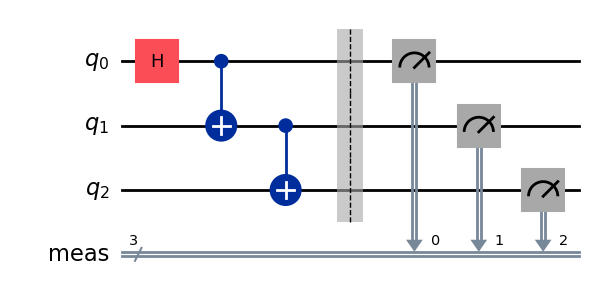

{'000': 49929, '111': 50071}


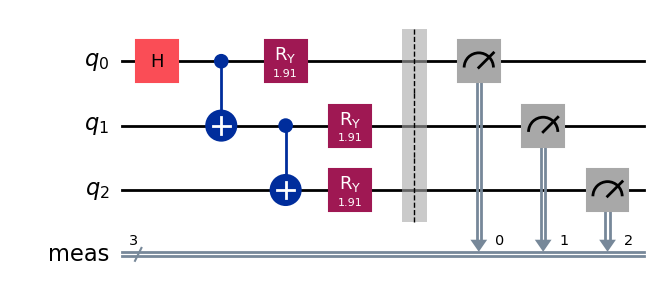

{'101': 655, '110': 632, '011': 657, '111': 26960, '000': 6286, '010': 21721, '001': 21550, '100': 21539}


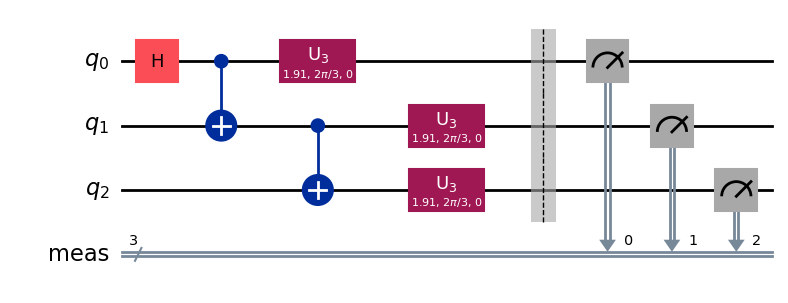

{'110': 611, '101': 645, '100': 21631, '001': 21758, '000': 6289, '010': 21303, '011': 643, '111': 27120}


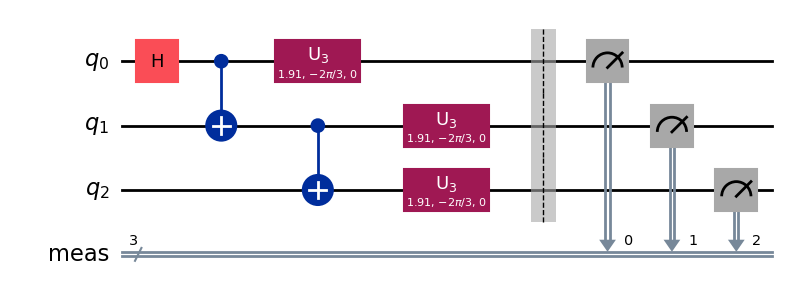

{'101': 704, '110': 602, '100': 21759, '001': 21533, '011': 618, '111': 27173, '000': 6191, '010': 21420}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Dataset and circuit saved.


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10, Loss: 76.9505


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/10, Loss: 11.4192


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.8077


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8738


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7410


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.7437


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8033


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7976


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.8189


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.8952


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1000, 16])
The fidelity for 3 qubits is 0.9610914122034567 with 1000 samples.


In [20]:
quantum_exp = QuantumExperiment(backend, n, shots)
quantum_exp.run_experiment()
quantum_exp.print_circuits_with_counts()
train_loader, test_loader, val_loader = load_data(quantum_exp,
                                                  first_run,
                                                  backend,
                                                  n,
                                                  shots,
                                                  split,
                                                  [batch_train, batch_test, batch_val],
                                                  shuffle, num_workers)

# Instantiate the model for the given parameters
model = SQVAE(n=n, batch_size=[batch_train, batch_train, batch_val],
              beta=0.819, num_steps=100, learning_rate=1e-3, device=device)

# Run the model and get the fidelity for the current parameter setting
fidelity_score = model.run(train=True, test=False, val=True,
                           train_loader=train_loader, test_loader=test_loader,
                           val_loader=val_loader, num_epochs=10)


In [21]:
# from google.colab import output
# output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google.colab'

In [23]:
# Reproduction of paper
parameters = [
    (3, 100, 20_000),
    (4, 200, 100_000),
    (5, 500, 4**5 * 500),  # 4^5 * 500
    (6, 600, 4**6 * 500),  # 4^6 * 500
    (7, 800, 4**7 * 500),  # 4^7 * 500
    (8, 1000, 4**8 * 500)  # 4^8 * 500
]

# Run the model for each parameter setting and calculate fidelity:
fidelities = []
for param in parameters:
    n, batch_train, batch_val = param  # Unpack parameters
    quantum_exp = QuantumExperiment(backend, n, shots)
    quantum_exp.run_experiment()
#     quantum_exp.print_circuits_with_counts()
    train_loader, test_loader, val_loader = load_data(quantum_exp,
                                                      first_run,
                                                      backend,
                                                      n,
                                                      shots,
                                                      split,
                                                      [batch_train, batch_test, batch_val],
                                                      shuffle, num_workers)

    # Instantiate the model for the given parameters
    model = SQVAE(n=n, batch_size=[batch_train, batch_train, batch_val],
                  beta=0.819, num_steps=100, learning_rate=1e-3, device=device)

    # Run the model and get the fidelity for the current parameter setting
    fidelity_score = model.run(train=True, test=False, val=True,
                               train_loader=train_loader, test_loader=test_loader,
                               val_loader=val_loader, num_epochs=10)

    # Append the fidelity score to the list
    fidelities.append(fidelity_score)

# Plot the histogram of fidelities
plot_histogram(fidelities, parameters)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Dataset and circuit saved.


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8713


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.3100


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.0699


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.0011


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9445


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8977


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8682


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.8587


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.8920


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.9047


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([20000, 16])


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 463.12 MiB is free. Process 2960 has 15.43 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 1.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)